This dataset provides data from 1st January 2013 to 24th April 2017 in the city of Delhi, India.
In this project we will discuss and do weather forcasting using time series analysis on  how the climate had changed through these years. The 4 parameters here are meantemp, humidity, wind_speed, meanpressure.

In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns


# Loading the data

In [62]:
df=pd.read_csv('\DailyDelhiClimateTrain.csv')


In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          1462 non-null   object 
 1   meantemp      1462 non-null   float64
 2   humidity      1462 non-null   float64
 3   wind_speed    1462 non-null   float64
 4   meanpressure  1462 non-null   float64
dtypes: float64(4), object(1)
memory usage: 57.2+ KB


In [64]:
#checking for any null values
df.isnull().sum()


date            0
meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64

# Feature Transformation

so far the only 2 features we need are the date and the meantemp, so we will drop the other columns

In [66]:
df.drop(['humidity', 'wind_speed','meanpressure'], axis=1,inplace=True)


In [67]:
df.head()

date   meantemp
0  2013-01-01  10.000000
1  2013-01-02   7.400000
2  2013-01-03   7.166667
3  2013-01-04   8.666667
4  2013-01-05   6.000000

now we need to transform the date into a datetime object and set it as an index

In [69]:
def make_date(row):
    return datetime(day = int(row.split('-')[2]), 
                    year = int(row.split('-')[0]), 
                    month = int(row.split('-')[1]))

In [70]:
df['date'] = df['date'].apply(make_date)
df.set_index(df.date,inplace=True)
df.drop(columns=['date'], inplace=True)

In [71]:
df.plot(figsize=(15,5))

<AxesSubplot:xlabel='date'>

as we can see,our data seems to be stationary, is shows kinda of a constant mean and variance.
we can also witness the seasonality throught out the year 
with the temprature being at its lowest at the begging and end of each year, and at its highest in the middle of the year.

In [78]:
sns.set(rc={"figure.figsize":(10, 5)})
sns.violinplot(x=df.index.month, y=df.meantemp)
plt.grid(b=True)


we can see here in the violin plot how our data carries so much seasonlaity again 

In [72]:
from statsmodels.tsa.stattools import adfuller
adfuller(df)


(-2.021069055920672,
 0.2774121372301608,
 10,
 1451,
 {'1%': -3.4348647527922824,
  '5%': -2.863533960720434,
  '10%': -2.567831568508802},
 5423.895746470953)

Since the p-value is not less than .05, we fail to reject the null hypothesis.and again we can confirm that our data is stationary

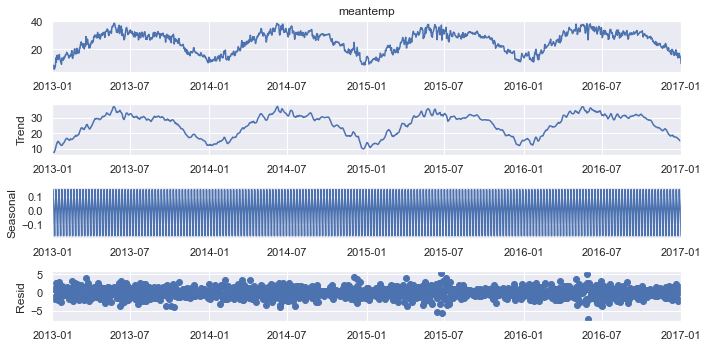

In [73]:
from statsmodels.tsa.seasonal import seasonal_decompose
seasonal_decompose(df['meantemp']).plot();


from decomposing our data, we can see that we have a strong seasonality and no trend at all since our data is stationary and has a constant mean.

In [74]:
seasonal_decompose(df['meantemp']).resid.plot(figsize=(12,4));


we can witness the residuals clearly here from our decomposition.

In [76]:
df2 = df.iloc[:-1 , :]


<AxesSubplot:xlabel='date'>

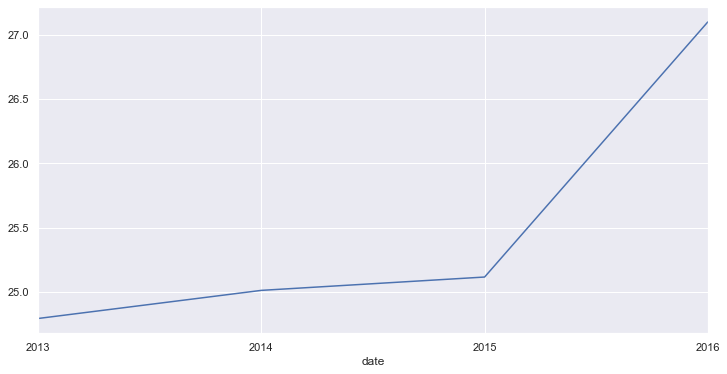

In [77]:
annual_temp = df2['meantemp'].resample('A').mean()
annual_temp.plot(figsize=(12,6))

we can see here how the temprature is increasing through the years and its sudden high increase rate between 2015 and 2016 with 3 degrees

In [80]:
from pmdarima import auto_arima

In [82]:
auto_arima(df.meantemp,seasonal=True).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1462
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -2768.239
Date:                Thu, 31 Mar 2022   AIC                           5542.478
Time:                        15:14:25   BIC                           5558.339
Sample:                             0   HQIC                          5548.395
                               - 1462                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5728      0.046     12.494      0.000       0.483       0.663
ma.L1         -0.8028      0.036    -22.070      0.000      -0.874      -0.731
sigma2         2.5896      0.072     36.204      0.000       2.449       2.730
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):               255.47
Prob(Q):                              0.76   Prob(JB):                         0.00
Heteroskedasticity (H):               0.80   Skew:                            -0.46
Prob(H) (two-sided):                  0.02   Kurtosis:                         4.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

so we did here the auto_arima to find the best model with the best p d and q 

# Split data into train and test

In [91]:
train = df[:-365]
test = df[-365:]

In [92]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model1 = SARIMAX(train['meantemp'],order=(1,1,1))
results1 = model1.fit()
results1.summary()

C:\Users\PC\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\PC\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               meantemp   No. Observations:                 1097
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -2079.286
Date:                Thu, 31 Mar 2022   AIC                           4164.573
Time:                        15:20:24   BIC                           4179.571
Sample:                    01-01-2013   HQIC                          4170.248
                         - 01-02-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5668      0.054     10.570      0.000       0.462       0.672
ma.L1         -0.7947      0.043    -18.502      0.000      -0.879      -0.711
sigma2         2.6020      0.081     32.123      0.000       2.443       2.761
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               257.05
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.90   Skew:                            -0.48
Prob(H) (two-sided):                  0.30   Kurtosis:                         5.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [93]:
start=len(train)
end=len(train)+len(test)-1
predictions1 = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMAX(1,1,1) Predictions')

<AxesSubplot:xlabel='date'>

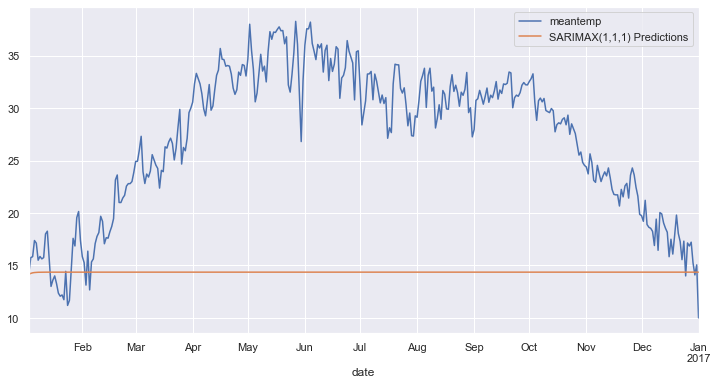

In [94]:
test['meantemp'].plot(legend=True,figsize=(12,6))
predictions1.plot(legend=True)

our model here did a poor job in predicting the mean temp throught the year

# Training the model to predict the temp through the month

In [96]:
monthly_temp = df['meantemp'].resample('MS').mean()

In [97]:
monthly_temp.plot(figsize=(12,6))

<AxesSubplot:xlabel='date'>

we can see here how much seasonality we have in the average temp of each months throught the year

In [99]:
auto_arima(monthly_temp,seasonal=True, m=12).summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                   49
Model:             SARIMAX(0, 0, 1)x(0, 1, [1, 2], 12)   Log Likelihood                 -68.565
Date:                                 Thu, 31 Mar 2022   AIC                            147.131
Time:                                         15:25:04   BIC                            155.185
Sample:                                              0   HQIC                           149.970
                                                  - 49                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.5113      0.214      2.387      0.017       0.092       0.931
ma.L1          0.4029      0.241      1.670      0.095      -0.070       0.876
ma.S.L12      -1.0644      0.616     -1.727      0.084      -2.272       0.144
ma.S.L24       0.6056      1.942      0.312      0.755      -3.202       4.413
sigma2         1.5569      1.628      0.956      0.339      -1.635       4.748
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                11.66
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               3.54   Skew:                            -0.90
Prob(H) (two-sided):                  0.04   Kurtosis:                         5.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [100]:
trainM = monthly_temp[:-13]
testM = monthly_temp[-13:]

In [101]:
model2 = SARIMAX(trainM,order=(0,0,1), seasonal_order=(0,1,[1,2],12), m=12)
results2 = model2.fit()
results2.summary()

C:\Users\PC\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                meantemp   No. Observations:                   36
Model:             SARIMAX(0, 0, 1)x(0, 1, [1, 2], 12)   Log Likelihood                 -37.238
Date:                                 Thu, 31 Mar 2022   AIC                             82.477
Time:                                         15:27:31   BIC                             87.189
Sample:                                     01-01-2013   HQIC                            83.727
                                          - 12-01-2015                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1136      0.204      0.557      0.578      -0.286       0.513
ma.S.L12      -1.4206    339.686     -0.004      0.997    -667.194     664.353
ma.S.L24       0.9895    315.911      0.003      0.998    -618.184     620.163
sigma2         0.4609    183.035      0.003      0.998    -358.280     359.202
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):                 0.51
Prob(Q):                              0.77   Prob(JB):                         0.77
Heteroskedasticity (H):               0.38   Skew:                             0.24
Prob(H) (two-sided):                  0.19   Kurtosis:                         2.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [109]:
start=len(trainM)
end=len(trainM)+len(testM)-1
predictions2 = results2.predict(start=start, end=end).rename('SARIMAX(0, 0, 1)x(0, 1, [1,2], 12) Predictions')

In [110]:
testM.plot(legend=True,figsize=(12,6))
predictions2.plot(legend=True)

<AxesSubplot:xlabel='date'>

our model here did  a better job at predicting the average temp in each month throught the year

# Results

comparing the two previous models, we can find that teh second model did a way better job than the first one and the plots show  a strong proof for the performances of these models

# Next Steps


to do a better job at predicting the mean temp of each day at the first model, we can try using deep learning techniques like lstm and RNN and see what results can we get